# Fix pathing

In [1]:
import sys


sys.path.append("..")


In [2]:
import constants

import os


constants.PROJECT_DIRECTORY_PATH = os.path.dirname(os.path.dirname(constants.PROJECT_DIRECTORY_PATH))


# Init

In [3]:
import datahandler

dataset_id = "oslo"

data_preprocessor = datahandler.DataPreprocessorOUS(dataset_id)
data_preprocessor.execute()

data_loader = datahandler.DataLoader(dataset_id)
data_loader.execute()


Loading dataset: 100%|██████████| 6/6 [00:18<00:00,  3.10s/it]


In [4]:
enhanced_data = data_loader.enhanced_incidents_df

In [5]:
import pandas as pd

enhanced_data['time_call_received'] = pd.to_datetime(enhanced_data['time_call_received'])

    # Extract various time segments from 'time_call_received'
enhanced_data['hour'] = enhanced_data['time_call_received'].dt.hour  # Hour of the day
enhanced_data['half_hour'] = enhanced_data['time_call_received'].dt.minute // 30  # Half-hour segments: 0 or 1
enhanced_data['every_20_minutes'] = enhanced_data['time_call_received'].dt.minute // 20  # 20-minute segments: 0, 1, or 2
enhanced_data['every_15_minutes'] = enhanced_data['time_call_received'].dt.minute // 15  # 15-minute segments: 0, 1, 2, or 3
enhanced_data['every_10_minutes'] = enhanced_data['time_call_received'].dt.minute // 10  # 10-minute segments: 0 to 5

# To further analyze or visualize these segments, you can group by these new columns
# For example, to count incidents per hour:
hourly_counts = enhanced_data.groupby('hour').size()

# If you want to see counts for more granular segments, you can group by multiple columns
# For example, incidents every 15 minutes:
every_15_min_counts = enhanced_data.groupby(['hour', 'every_15_minutes']).size()

# Print the counts for inspection
print(hourly_counts)
print(every_15_min_counts)

# You can repeat this grouping and counting for the other time segments as needed


hour
0     13748
1     12348
2     11050
3     10198
4      8246
5      7827
6      8325
7     10499
8     15154
9     19210
10    21853
11    22127
12    20871
13    22093
14    21487
15    19905
16    20541
17    19875
18    19840
19    20149
20    20124
21    19886
22    16692
23    15151
dtype: int64
hour  every_15_minutes
0     0                   3557
      1                   3549
      2                   3344
      3                   3298
1     0                   3244
                          ... 
22    3                   4000
23    0                   3772
      1                   3964
      2                   3737
      3                   3678
Length: 96, dtype: int64


In [6]:
# Calculate frequencies and normalize for each time segment
def calculate_probabilities(df, time_segment):
    # Group by the specified time segment and count incidents
    counts = df.groupby(time_segment).size()
    
    # Normalize counts to probabilities
    probabilities = counts / counts.sum()
    
    return probabilities

# Hourly distribution
hourly_probabilities = calculate_probabilities(enhanced_data, 'hour')

# Half-hourly distribution
half_hourly_probabilities = calculate_probabilities(enhanced_data, ['hour', 'half_hour'])

# Every 20 minutes distribution
every_20_minutes_probabilities = calculate_probabilities(enhanced_data, ['hour', 'every_20_minutes'])

# Every 15 minutes distribution
every_15_minutes_probabilities = calculate_probabilities(enhanced_data, ['hour', 'every_15_minutes'])

# Every 10 minutes distribution
every_10_minutes_probabilities = calculate_probabilities(enhanced_data, ['hour', 'every_10_minutes'])

# Save the distributions to CSV files
hourly_probabilities.to_csv('hourly_distribution.csv', header=['probability'])
half_hourly_probabilities.to_csv('half_hourly_distribution.csv', header=['probability'])
every_20_minutes_probabilities.to_csv('every_20_minutes_distribution.csv', header=['probability'])
every_15_minutes_probabilities.to_csv('every_15_minutes_distribution.csv', header=['probability'])
every_10_minutes_probabilities.to_csv('every_10_minutes_distribution.csv', header=['probability'])


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_probability_distribution(csv_file, title):
    # Load the probabilities from the CSV file
    df = pd.read_csv(csv_file)
    num_segments = len(df)
    
    # Generate x-axis labels dynamically based on the number of segments
    if "hourly" in csv_file:
        x_labels = [f"{i}:00" for i in range(num_segments)]
    elif "half_hourly" in csv_file:
        x_labels = [f"{i//2}:{'00' if i % 2 == 0 else '30'}" for i in range(num_segments * 2)]
    elif "every_20_minutes" in csv_file or "every_15_minutes" in csv_file or "every_10_minutes" in csv_file:
        # For these, we need a more complex logic to accurately generate labels if not directly inferable from the data
        x_labels = df.index.astype(str)  # Using index as a fallback. You might need a custom logic here.

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(range(num_segments), df['probability'], tick_label=x_labels[:num_segments], width=0.4)
    
    plt.title(title)
    plt.xlabel('Time Segment')
    plt.ylabel('Probability')
    plt.xticks(rotation=90)  # Rotate for visibility
    
    plt.tight_layout()
    plt.show()

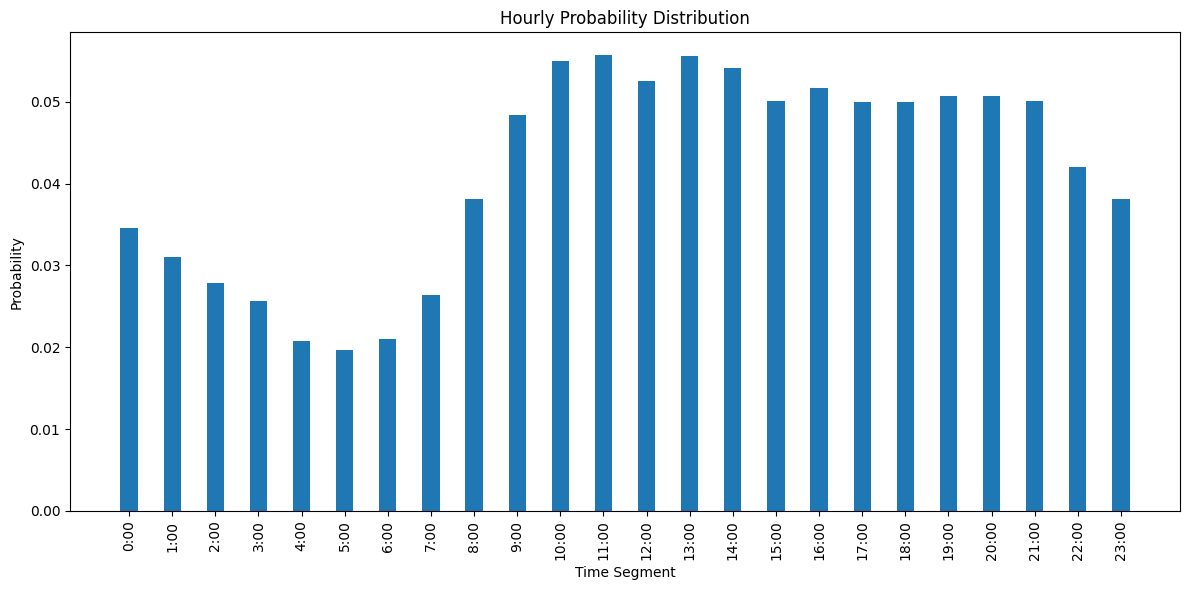

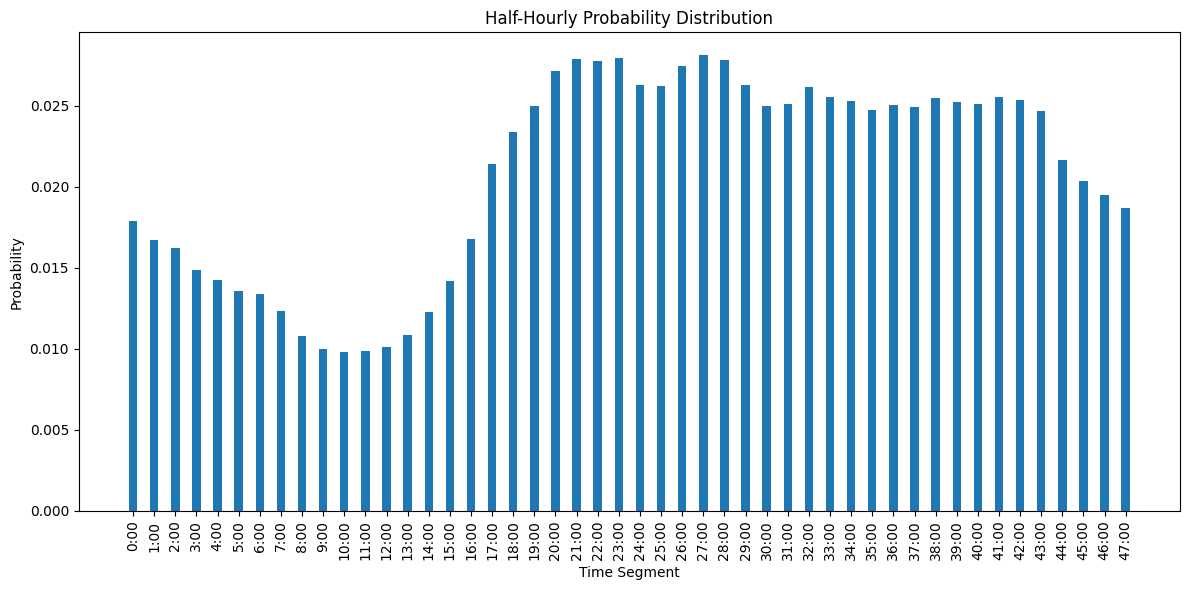

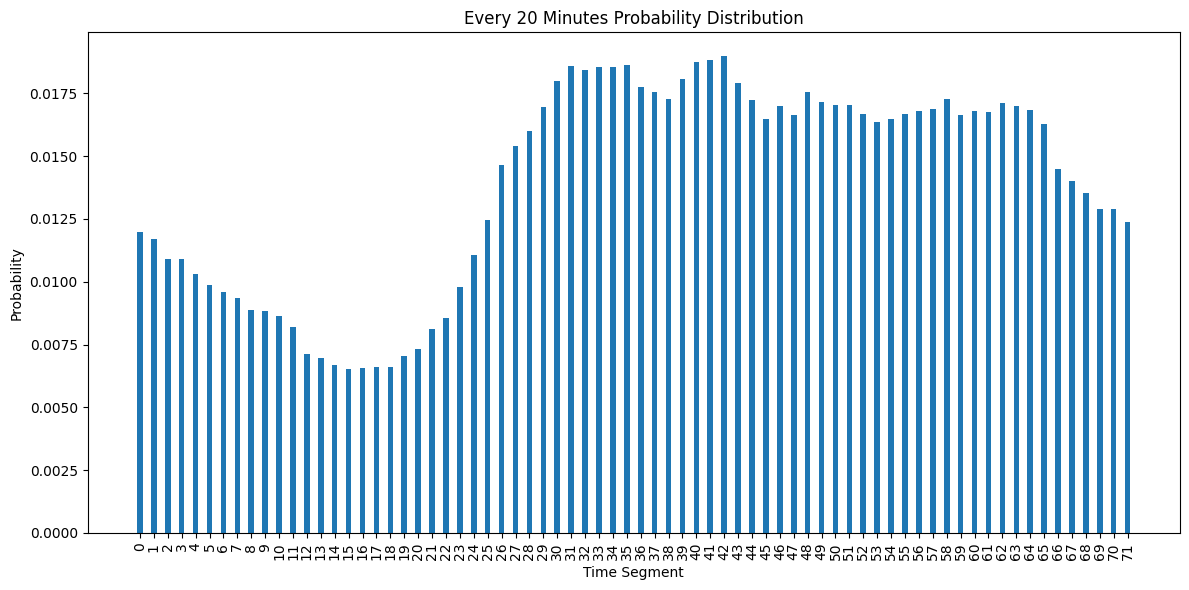

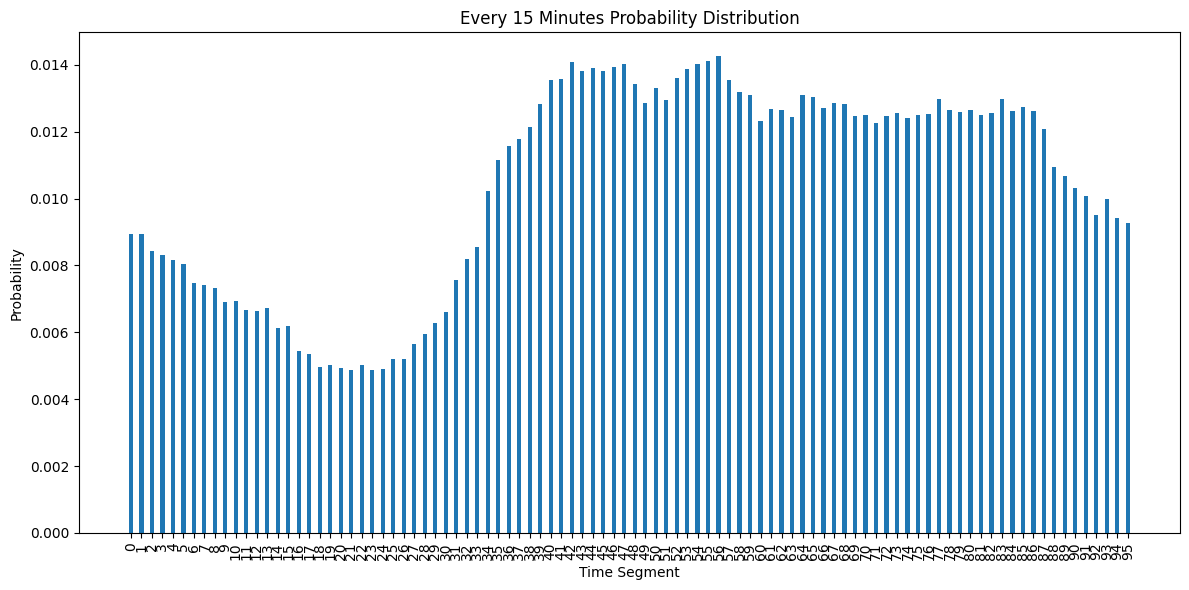

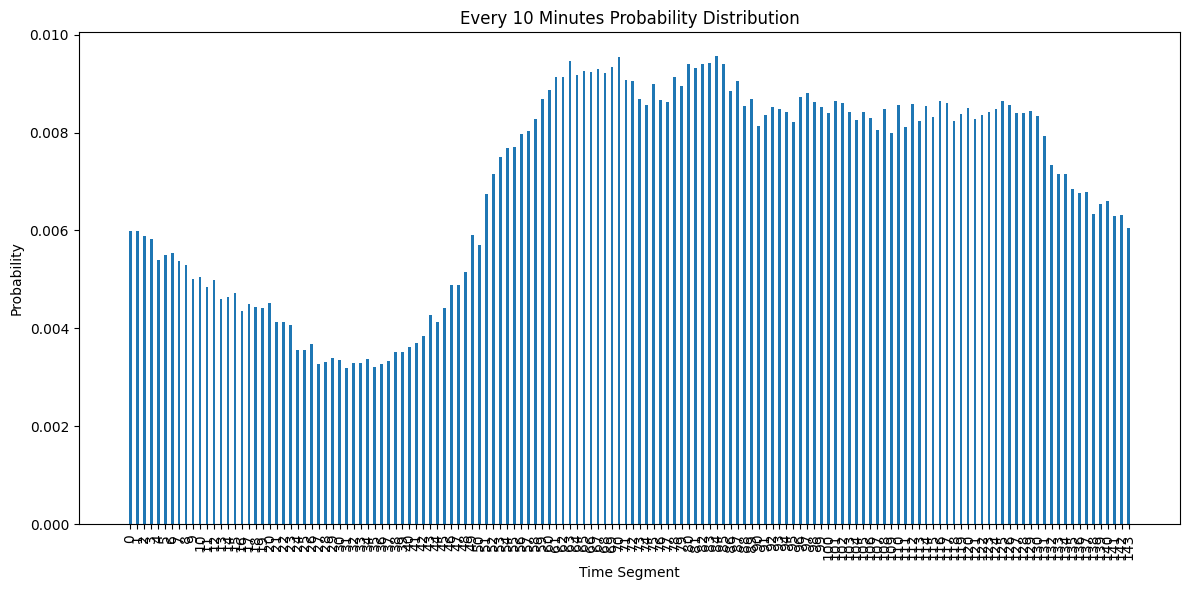

In [10]:
plot_probability_distribution('hourly_distribution.csv', 'Hourly Probability Distribution')
plot_probability_distribution('half_hourly_distribution.csv', 'Half-Hourly Probability Distribution')
plot_probability_distribution('every_20_minutes_distribution.csv', 'Every 20 Minutes Probability Distribution')
plot_probability_distribution('every_15_minutes_distribution.csv', 'Every 15 Minutes Probability Distribution')
plot_probability_distribution('every_10_minutes_distribution.csv', 'Every 10 Minutes Probability Distribution')

In [13]:
def calculate_spatial_distribution(df):
    """
    Calculate the spatial distribution of incidents across grid cells from the input DataFrame.
    This method calculates both the frequency and probability of incidents in each grid cell
    and saves the results to CSV files named 'grid_frequencies.csv' and 'grid_probabilities.csv'.

    Parameters:
    - df: DataFrame containing the incidents data with columns 'grid_row' and 'grid_col'.
    """

    # Step 1: Group by grid_row and grid_col to calculate frequencies
    grid_frequencies = df.groupby(['grid_row', 'grid_col']).size().reset_index(name='counts')

    # Step 2: Normalize counts to get probabilities
    total_incidents = grid_frequencies['counts'].sum()
    grid_frequencies['probability'] = grid_frequencies['counts'] / total_incidents

    # Save frequencies to CSV (with counts)
    grid_frequencies[['grid_row', 'grid_col', 'counts']].to_csv('grid_frequencies.csv', index=False)

    # Save probabilities to CSV (with probabilities)
    grid_frequencies[['grid_row', 'grid_col', 'probability']].to_csv('grid_probabilities.csv', index=False)

    print("Spatial distribution calculated and saved to 'grid_frequencies.csv' and 'grid_probabilities.csv'.")


In [14]:
calculate_spatial_distribution(enhanced_data)

Spatial distribution calculated and saved to 'grid_frequencies.csv' and 'grid_probabilities.csv'.


In [18]:
def calculate_spatiotemporal_distribution(temporal_csv, spatial_csv):
    """
    Calculate a 2D spatiotemporal probability distribution from temporal and spatial distributions.

    Parameters:
    - temporal_csv: Path to the CSV file containing the temporal distribution.
    - spatial_csv: Path to the CSV file containing the spatial distribution.

    Returns:
    - A DataFrame containing the spatiotemporal distribution.
    """
    # Read the CSV files
    temporal_df = pd.read_csv(temporal_csv)
    spatial_df = pd.read_csv(spatial_csv)
    
    # Initialize a list to store spatiotemporal data
    spatiotemporal_data = []

    # Iterate through each spatial segment and combine with temporal segments
    for _, spatial_row in spatial_df.iterrows():
        for _, temporal_row in temporal_df.iterrows():
            # Calculate the spatiotemporal probability
            spatiotemporal_probability = spatial_row['probability'] * temporal_row['probability']
            # Create a dictionary for the new row
            new_row = {
                'grid_row': spatial_row['grid_row'], 
                'grid_col': spatial_row['grid_col'],
                'probability': spatiotemporal_probability
            }
            # For temporal datasets with more granularity
            if 'hour' in temporal_df.columns:
                new_row['hour'] = temporal_row['hour']
            if 'every_20_minutes' in temporal_df.columns:
                new_row['every_20_minutes'] = temporal_row['every_20_minutes']
            
            # Append the dictionary to the list
            spatiotemporal_data.append(new_row)

    # Convert the list of dictionaries to a DataFrame
    spatiotemporal_df = pd.DataFrame(spatiotemporal_data)

    return spatiotemporal_df

In [19]:
temporal_distribution = 'hourly_distribution.csv'
spatial_distribution = 'grid_probabilities.csv'

# Example usage:
spatiotemporal_df = calculate_spatiotemporal_distribution(temporal_distribution, spatial_distribution)

# You can then save this DataFrame to a CSV or use it directly:
spatiotemporal_df.to_csv('spatiotemporal_distribution.csv', index=False)
